# Variational Quantum Image Classifier

This project is based on the IBM Quantum course https://learning.quantum.ibm.com/course/quantum-machine-learning/quantum-neural-networks

## Data Base



In [ ]:
#This code defines the images to be classified:

import numpy as np 

#Total number of "pixels"/qubits
size = 8
#One dimension of the image (called vertical, but it doesn't matter). Must be a divisor of `size`
vert_size = 2
#The lenth of the line to be detected (yellow). Must be less than or equal to the smallest dimension of the image (`<=min(vert_size,size/vert_size)`
line_size = 2

def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((size-(line_size-1)*vert_size, size))
    ver_array = np.zeros((round(size/vert_size)*(vert_size-line_size+1), size))

    
    j = 0
    for i in range(0, size-1):
        if i%((size/vert_size)) <= ((size/vert_size))-line_size:
            for p in range(0,line_size):
                hor_array[j][i+p] = np.pi / 2
            j += 1
  
    #Make two adjacent entries pi/2, then move down to the next row. Careful to avoid the "pixels" at size/vert_size - linesize, because we want to fold this list into a grid.
    
    j = 0
    for i in range(0, round(size/vert_size)*(vert_size-line_size+1)):
        for p in range(0,line_size):
            ver_array[j][i + p*round(size/vert_size)] = np.pi / 2
        j += 1

    #Make entries pi/2, spaced by the length/rows, so that when folded, the entries appear on top of each other.

    for n in range(num_images):
        rng = np.random.randint(0, 2)
        if rng == 0:
            labels.append(-1)
            random_image = np.random.randint(0, len(hor_array))
            images.append(np.array(hor_array[random_image]))

        elif rng == 1:
            labels.append(1)
            random_image = np.random.randint(0, len(ver_array))
            images.append(np.array(ver_array[random_image]))
            #Randomly select 0 or 1 for a horizontal or vertical array, assign the corresponding label.

        # Create noise
        for i in range(size):
            if images[-1][i] == 0:
                images[-1][i] = np.random.rand() * np.pi / 4
    return images, labels

hor_size = round(size/vert_size)


from sklearn.model_selection import train_test_split

np.random.seed(42)
images, labels = generate_dataset(200)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=246
)

import matplotlib.pyplot as plt

# Make subplot titles so we can identify categories
titles = []
for i in range(8):
    title = 'category: ' + str(train_labels[i])
    titles.append(title)

# Generate a figure with nested images using subplots.
fig, ax = plt.subplots(4, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})

for i in range(8):
    ax[i // 2, i % 2].imshow(
        train_images[i].reshape(vert_size, hor_size),
        aspect="equal",
    )
    ax[i // 2, i % 2].set_title(titles[i])
plt.subplots_adjust(wspace=0.1, hspace=0.3)

## Dimensionality Reduction & Qubit Count

The following steps aim to reduce the 8×8 image data (64 features) to a smaller set of principal components and map them to qubits for quantum kernel classification.

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit the scaler on the training data
train_scaled = scaler.fit_transform(data_train)
test_scaled = scaler.transform(data_test)

# Fit PCA to training data
pca = PCA(n_components=0.85)
train_pca = pca.fit_transform(train_scaled)
test_pca = pca.transform(test_scaled)

# Examine explained variance and component count
n_components = pca.n_components_
explained_variance = pca.explained_variance_ratio_.sum()
print(f"Selected {n_components} components, explaining {explained_variance:.2%} variance.")

Selected 26 components, explaining 98.02% variance.


## Maping the qubits

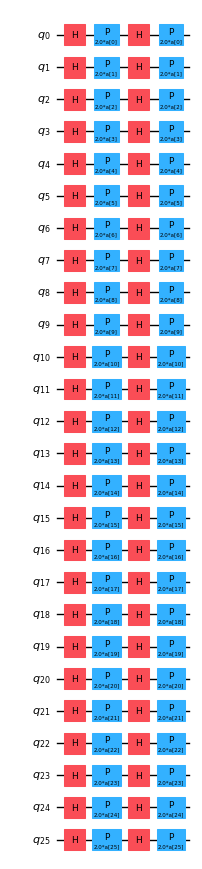

In [49]:
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap

feature_map = ZFeatureMap(n_components, reps=2, parameter_prefix='a')

feature_map.decompose().draw('mpl', scale=0.5)

## Ansatz Construcction


11
2+ qubit depth: 9


11
2+ qubit depth: 9


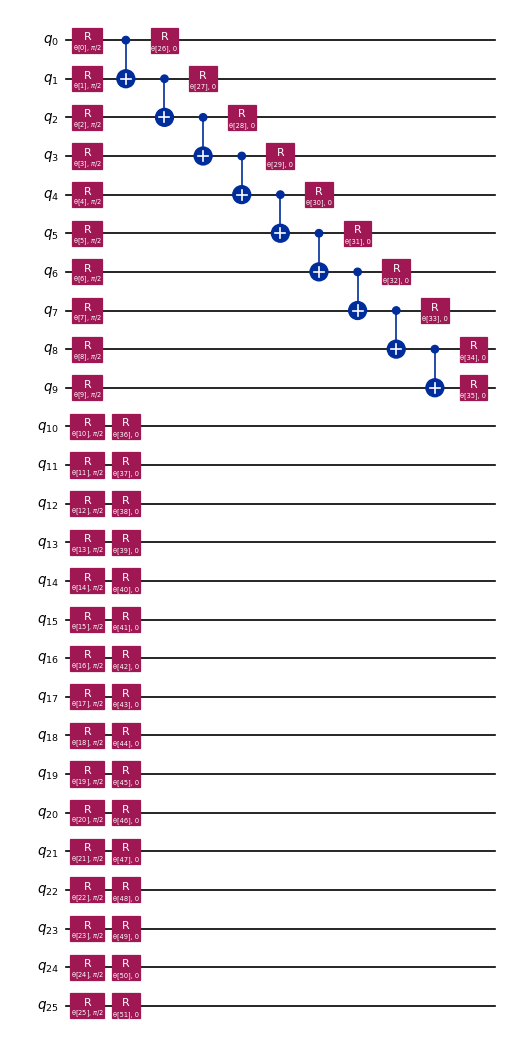

In [50]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

#Initialize the circuit using the same number of qubits as the image has pixels
qnn_circuit = QuantumCircuit(n_components)

#We choose to have two variational parameters for each qubit.
params = ParameterVector("θ", length=2*n_components)

#A first variational layer:
for i in range(n_components):
    qnn_circuit.ry(params[i],i)

#Here is a list of qubit pairs between which we want CNOT gates. The choice of these is not yet obvious.
qnn_cnot_list = [[0,1],[1,2],[2,3]]

for i in range(len(qnn_cnot_list)):
    qnn_circuit.cx(qnn_cnot_list[i][0],qnn_cnot_list[i][1])

#The second variational layer:
for i in range(n_components):
    qnn_circuit.rx(params[n_components+i],i)

#Check the circuit depth, and the two-qubit gate depth
print(qnn_circuit.decompose().depth())
print(f"2+ qubit depth: {qnn_circuit.decompose().depth(lambda instr: len(instr.qubits) > 1)}")

#Draw the circuit
qnn_circuit.decompose().draw("mpl", scale=0.6)

## Merging both ansatz and feature map

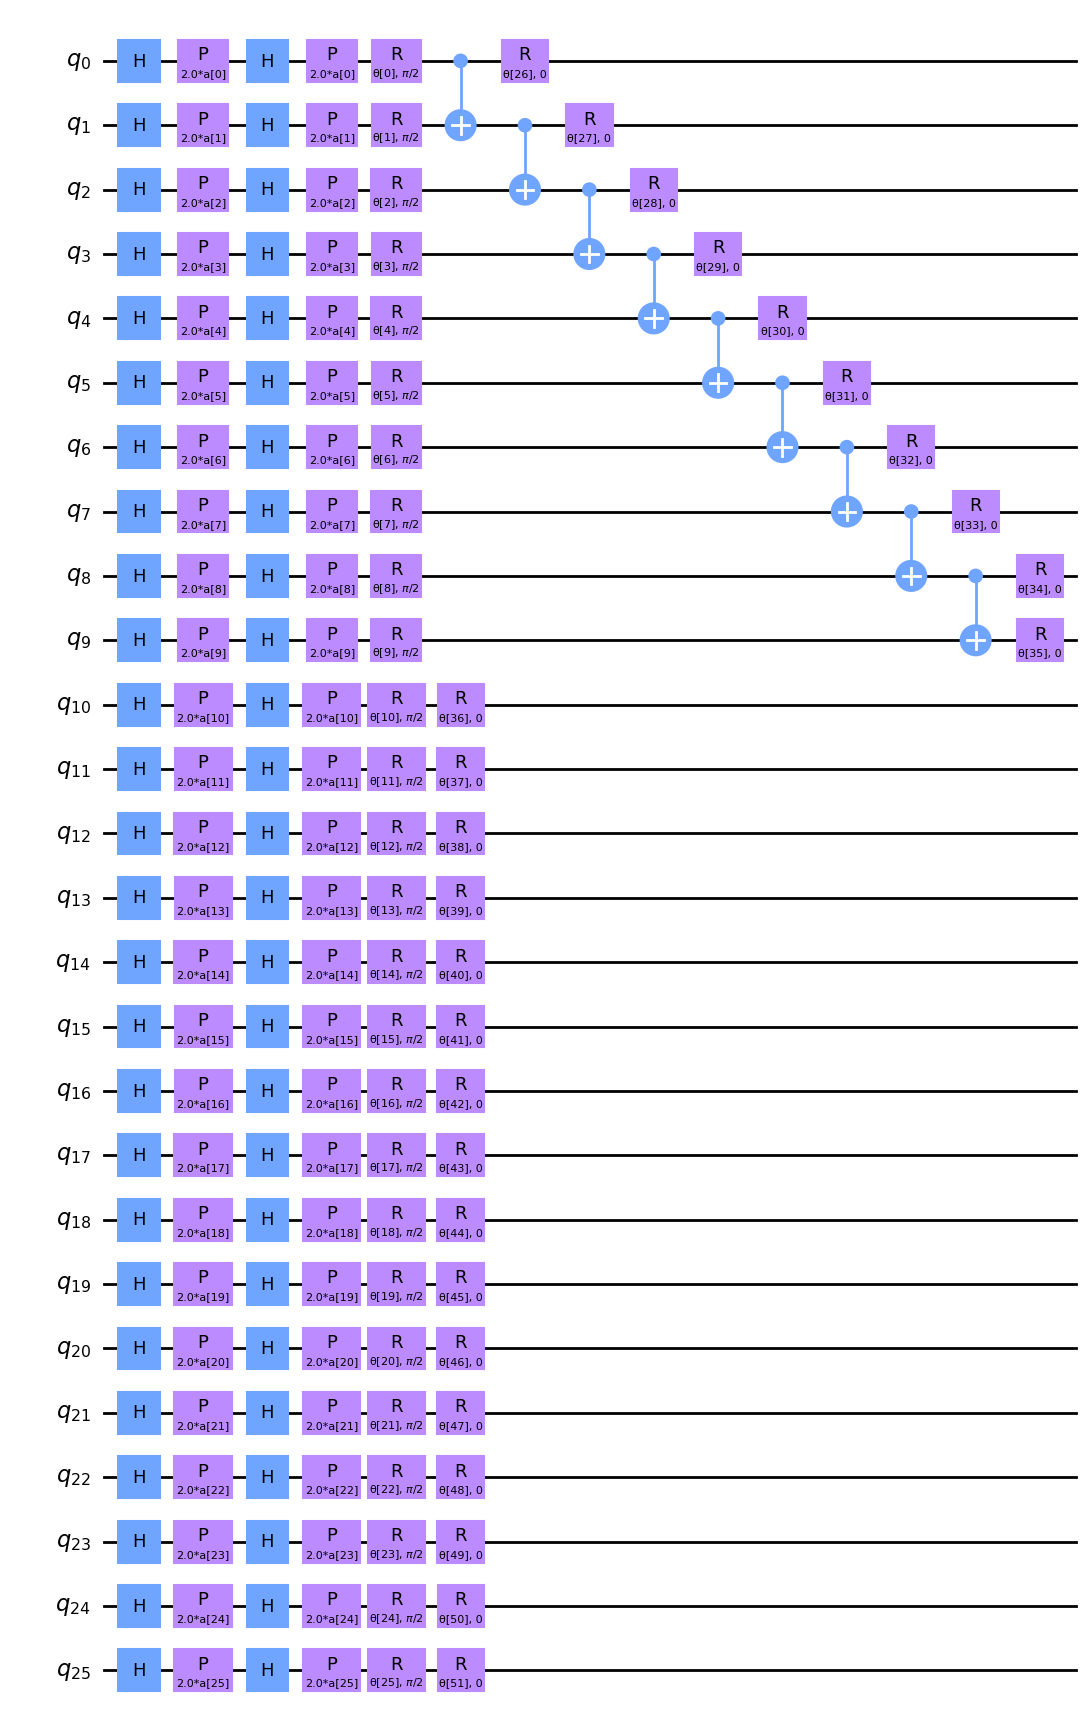

In [51]:
#QNN ansatz
ansatz = qnn_circuit

# Combine the feature map with the ansatz
full_circuit = QuantumCircuit(n_components)
full_circuit.compose(feature_map, range(n_components), inplace=True)
full_circuit.compose(ansatz, range(n_components), inplace=True)

# Display the circuit
full_circuit.decompose().draw("mpl", style="clifford", fold=-1)

## Defining an osbservable

In [52]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp.from_list([("Z" * (n_components), 1)])

## Some important functions

First, we need a function to run a forward pass.

In [ ]:
from qiskit.primitives import BaseEstimatorV2
from qiskit.quantum_info.operators.base_operator import BaseOperator

def forward(circuit: QuantumCircuit,
            input_params: np.ndarray, 
            weight_params: np.ndarray, 
            estimator: BaseEstimatorV2,
            observable: BaseOperator,
) -> np.ndarray:
    """
    Forward pass of the neural network.
    
    Args:
        circuit: circuit consisting of data loader gates and the neural network ansatz.
        input_params: data encoding parameters.
        weight_params: neural network ansatz parameters.
        estimator: EstimatorV2 primitive. 
        observable: a single oberservable to compute the expectation over.

    Returns:
        expectation_values: an array (for one observable) or a matrix (for a sequence of observables) of expectation values.
        Rows correspond to observables and columns to data samples.
    """
    num_samples = input_params.shape[0]
    weights = np.broadcast_to(weight_params, (num_samples, len(weight_params)))
    params = np.concatenate((input_params, weights), axis=1)
    pub = (circuit, observable, params)
    job = estimator.run([pub])
    result = job.result()[0]
    expectation_values = result.data.evs

    return expectation_values

Next, we need a loss function to calculate the difference between the predicted and calculated values of the labels. The function will take in the labels predicted by the algorithm and the correct labels and return the mean squared difference. There any many different loss functions. Here, MSE is an example that we chose.

In [54]:
def mse_loss(predict: np.ndarray, target: np.ndarray) -> np.ndarray:
    """
    Mean squared error (MSE).

    prediction: predictions from the forward pass of neural network.
    target: true labels.

    output: MSE loss.
    """
    if len(predict.shape) <= 1:
        return ((predict - target) ** 2).mean()
    else:
        raise AssertionError ("input should be 1d-array")

Let us also define a slightly different loss function that is a function of the variable parameters (weights), for use by the classical optimizer. This function only takes the ansatz parameters as input; other variables for the forward pass and the loss are set as global parameters. The optimizer will train the model by sampling different weights and attempting to lower the output of the cost/loss function.

In [55]:
def mse_loss_weights(weight_params: np.ndarray) -> np.ndarray:
    """
    Cost function for the optimizer to update the ansatz parameters.

    weight_params: ansatz parameters to be updated by the optimizer.

    output: MSE loss.
    """
    predictions = forward(circuit=circuit, 
                          input_params=input_params, 
                          weight_params=weight_params, 
                          estimator=estimator, 
                          observable=observable)
    
    cost = mse_loss(predict=predictions, target=target)
    objective_func_vals.append(cost)
    
    global iter
    if iter % 50 == 0:
        print(f"Iter: {iter}, loss: {cost}")
    iter += 1

    return cost

We will set some initial global variables for the cost function.

In [56]:
# Globals
circuit = full_circuit
observables = observable
#input_params = train_images_batch
#target = train_labels_batch
objective_func_vals = []
iter = 0

## Optimize problem for quantum execution 

We start by selecting a backend for execution. In this case, we will use the least-busy backend.

In [57]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator


service = QiskitRuntimeService(channel="ibm_quantum", instance="ibm-q/open/main")
backend = service.least_busy(operational=True, simulator=False)


print(backend.name)

ibm_brisbane


Here we optimize the circuit for running on a real backend by specifying the optimization_level and adding dynamical decoupling. The code below generates a pass manager using preset pass managers from qiskit.transpiler.

In [58]:
from qiskit.circuit.library import XGate
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import (
    ALAPScheduleAnalysis,
    ConstrainedReschedule,
    PadDynamicalDecoupling,
)
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
pm.scheduling = PassManager(
    [
        ALAPScheduleAnalysis(target=target),
        ConstrainedReschedule(target.acquire_alignment, target.pulse_alignment),
        PadDynamicalDecoupling(
            target=target, dd_sequence=[XGate(), XGate()], pulse_alignment=target.pulse_alignment
        ),
    ]
)

Now we use the pass manager on the circuit. The layout changes that result must be applied to the observable as well. For very large circuits, the heuristics used in circuit optimization may not always yield the best and shallowest circuit. In those cases it makes sense to run such pass managers several times and use the best circuit. 

In [59]:
circuit_ibm = pm.run(full_circuit)
observable_ibm = observable.apply_layout(circuit_ibm.layout)

## Execute using Qiskit Primitives

In [ ]:
from scipy.optimize import minimize
from qiskit.primitives import StatevectorEstimator as Estimator

# Convertir etiquetas a números (0 para Circle, 1 para Cross)
numeric_labels_train = np.array([1 if label == 'Cross' else 0 for label in labels_train])

batch_size = 140  
num_epochs = 1
#num_samples = len(train_pca)
num_samples = len(data_train)

# Globals
circuit = full_circuit
estimator = Estimator()  # simulator for debugging
observables = observable
objective_func_vals = []
iter = 0

# Random initial weights for the ansatz
np.random.seed(42)
weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi

for epoch in range(num_epochs):
    for i in range((num_samples - 1) // batch_size + 1):
        print(f"Epoch: {epoch}, batch: {i}")
        start_i = i * batch_size
        end_i = min(start_i + batch_size, num_samples)  # Evitar índices fuera de rango
        
        # Usar train_pca para features y numeric_labels_train para etiquetas
        train_images_batch = data_train[start_i:end_i]
        train_labels_batch = numeric_labels_train[start_i:end_i]
        
        input_params = train_images_batch
        target = train_labels_batch
        iter = 0
        
        res = minimize(mse_loss_weights, weight_params, method='COBYLA', options={'maxiter': 100})
        weight_params = res['x']
        
        print(f"Batch loss: {res.fun}")

Epoch: 0, batch: 0


## Post-process

In [ ]:
import copy
from sklearn.metrics import accuracy_score
from qiskit.primitives import StatevectorEstimator as Estimator  # simulator
# from qiskit_ibm_runtime import EstimatorV2 as Estimator  # real quantum computer

estimator = Estimator()
# estimator = Estimator(backend=backend)

pred_train = forward(circuit, np.array(train_pca), res['x'], estimator, observable)
# pred_train = forward(circuit_ibm, np.array(train_pca), res['x'], estimator, observable_ibm)

print("Predicciones brutas del modelo:")
print(pred_train)

# Convertir predicciones a etiquetas binarias
pred_train_labels = copy.deepcopy(pred_train)
pred_train_labels[pred_train_labels >= 0] = 1
pred_train_labels[pred_train_labels < 0] = 0  # Cambiado de -1 a 0 para coincidir con numeric_labels_train

print("\nPredicciones convertidas a etiquetas binarias (1=Cross, 0=Circle):")
print(pred_train_labels)

# Usar las mismas etiquetas numéricas que usamos en el entrenamiento
numeric_labels_test = np.array([1 if label == 'Cross' else 0 for label in labels_train])
print("\nEtiquetas reales convertidas a formato numérico (1=Cross, 0=Circle):")
print(numeric_labels_test)

accuracy = accuracy_score(numeric_labels_test, pred_train_labels)
print(f"\nPrecisión del entrenamiento: {accuracy * 100:.2f}%")

Predicciones brutas del modelo:
[ 1.40595201e-04  3.24868337e-03 -1.59664061e-05  7.47955128e-03
  4.15643097e-03 -1.02763425e-04 -3.31331598e-04 -1.12587350e-02
 -3.24961670e-03  7.04206490e-04 -8.33262799e-04 -1.68729130e-03
 -5.96541804e-04  7.32737886e-04  1.22422414e-03 -9.15565274e-05
  9.69915438e-04 -6.35806590e-04  8.06806291e-05 -2.35877675e-04
 -1.47081273e-04 -3.73587712e-04  2.18541641e-05  1.07267084e-03
  1.50400072e-03 -1.14779769e-07  3.14784220e-04  1.13284084e-03
 -6.99497892e-04  1.00270679e-03  3.11763382e-04 -1.09577526e-05
 -7.04599882e-04 -1.44250493e-03  1.73838341e-04 -2.76480012e-05
 -1.12576494e-05 -4.74795340e-04 -1.44920909e-04 -6.71771011e-04]

Predicciones convertidas a etiquetas binarias (1=Cross, 0=Circle):
[1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1.
 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]

Etiquetas reales convertidas a formato numérico (1=Cross, 0=Circle):
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0